<a href="https://colab.research.google.com/github/dotimothy/DuckDetector/blob/model/TrainDuckDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦆 DuckDetector: A Project for Automatically Detecting Ducks 🦆
This notebook covers training the YOLOv8 Object Detection Models which will be deployed on various user interfaces.

**Author:** [Timothy Do](https://timothydo.me)

<a href="https://colab.research.google.com/github/dotimothy/DuckDetector/blob/model/TrainDuckDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
This section checks the adequate preqrequisites are installed in the Python environment and also install additional dependencies depending if the user is running Google CoLab or not. Before you begin, make sure to have the following external prerequisites installed:
- ffmpeg

In [1]:
# Check if Environment is in Google CoLab:
IN_COLAB = True
try:
    import google.colab
except:
    IN_COLAB = False

In [2]:
if(IN_COLAB):
    !curl https://raw.githubusercontent.com/dotimothy/DuckDetector/model/requirements.txt -o ./requirements.txt
    !apt install ffmpeg
!pip install -r requirements.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1653  100  1653    0     0  23205      0 --:--:-- --:--:-- --:--:-- 23281
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
# Importing Libraries
import os
import sys
import torch
import cv2 as cv
import numpy as np
import cpuinfo
import psutil
import ultralytics
import pandas as pd
from tqdm import tqdm
import random
from openimages.download import download_dataset
import matplotlib.pyplot as plt
import re
import shutil
from IPython.display import Video

# For Printing Purposes
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

To adequately train the DuckDetector, make sure a GPU is detected in the runtime. GPU accelerates the developnment of AI models by parallelizing matrix multiplication and convolution operations that are nececssary to accelerate gradient backpropogation for effcient learning.

In [4]:
# Environment Specifications

print(f'{color.BOLD}***** Environment Specifications *****{color.END}')
print(f"{color.BOLD}In CoLab{color.END}: {IN_COLAB}")
# Device to Develop PyTorch Models On
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device = torch.device('cuda' if use_cuda else ('mps' if use_mps else 'cpu'))
print(f'{color.BOLD}Torch Device:{color.END} {device}')
platformToOS = {'darwin': 'MacOS', 'win32': 'Windows', 'linux2': 'Linux', 'linux': 'Linux'}
print(f'{color.BOLD}OS:{color.END} {platformToOS[sys.platform]}')
print(f'{color.BOLD}CPU:{color.END} {cpuinfo.get_cpu_info()["brand_raw"]}')
print(f'\t- {color.BOLD}# CPU Cores:{color.END} {psutil.cpu_count(logical=False)}')
print(f'\t- {color.BOLD}# CPU Threads:{color.END} {psutil.cpu_count(logical=True)}')
print(f'\t- {color.BOLD}Total System RAM:{color.END} {psutil.virtual_memory().total/(1024**3):.1f} GB ')
print(f'\n{color.BOLD}GPU:{color.END} {torch.cuda.get_device_name(device) if use_cuda else "MPS" if use_mps else None}')
if(use_cuda):
    print(f'\t- {color.BOLD}Total GPU VRAM:{color.END} {torch.cuda.get_device_properties(device).total_memory/(1024**3):.1f} GB\n')
    !nvidia-smi

***** Environment Specifications *****
In CoLab: True
Torch Device: cuda
OS: Linux
CPU: Intel(R) Xeon(R) CPU @ 2.00GHz
	- # CPU Cores: 1
	- # CPU Threads: 2
	- Total System RAM: 12.7 GB 

GPU: Tesla T4
	- Total GPU VRAM: 14.7 GB

Thu Aug  8 19:25:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8 

## Dataset Preprocessing
This section covers how to download various datasets and unify them under a common standard for training the duck detection models. The [spreadsheet](https://docs.google.com/spreadsheets/d/1AfuZ8lFaX3Iy5eNDXTxvasOeE4mqal2Pe8c--oDRmOg/edit?usp=sharing) of each individual dataset viewable in the cell below:

In [5]:
dataset_df = pd.read_csv('https://docs.google.com/spreadsheets/d/1AfuZ8lFaX3Iy5eNDXTxvasOeE4mqal2Pe8c--oDRmOg/export?format=csv')
display(dataset_df)

,Name,# of Images,Original Source,ImagesCV,Include Cartoon,Link
0,OpenImages (Duck),1289,Open Images Dataset V7,No,No,https://storage.googleapis.com/openimages/web/...
1,OpenImages (Goose),577,Open Images Dataset V7,No,No,https://storage.googleapis.com/openimages/web/...
2,Wood Duck,216,300 Bird Species Classification,Yes,No,https://images.cv/dataset/wood-duck-image-clas...
3,Teal Duck,167,300 Bird Species Classifcation,Yes,No,https://images.cv/dataset/teal-duck-image-clas...
4,Steamer Duck,122,300 Bird Species Classification,Yes,No,https://images.cv/dataset/steamer-duck-image-c...
5,Red Headed Duck,127,300 Bird Species Classification,Yes,No,https://images.cv/dataset/red-headed-duck-imag...
6,Mandrin Duck,134,300 Bird Species Classification,Yes,No,https://images.cv/dataset/mandrin-duck-image-c...
7,Mallard Duck,140,300 Bird Species Classification,Yes,No,https://images.cv/dataset/mallard-duck-image-c...
8,Duck,1000,Domainnet,Yes,Yes,https://images.cv/dataset/duck-image-classific...
9,Drake,1300,Imagenet Object Localization,Yes,No,https://images.cv/dataset/drake-image-classifi...


### OpenImages
This section will overview Google's already annotated image sets for the **Duck** and the **Goose** from their [Openimages](https://storage.googleapis.com/openimages/web/index.html) dataset. Each subset has the following amount of images:

**Duck**
- Train: 1151 Images
- Validation: 37 Images
- Test: 101 Images
- **Total:** 1289 Images

**Goose**
- Train: 518 Images
- Validation: 16 Images
- Test: 43 Images
- **Total:** 577 Images

It is to be noted that the *openimages* API merges the train/val/test subsets all into a single collection (i.e., all images are merged into a single folder, anonymizing which subset each one was in).

In [6]:
# Downloading the OpenImages Subset of Duck and Goose
dataPath = './data/'
openPath = f'{dataPath}/OpenImages/'
duckPath = f'{openPath}/duck/'
goosePath = f'{openPath}/goose/'
if(not(os.path.exists(dataPath))): os.mkdir(dataPath) # Making Data Directory
if(not(os.path.exists(openPath))): os.mkdir(openPath) # Making OpenImages Directory
if(not(os.path.exists(duckPath))): # Downloading Duck Subset
    print(f'***** Downloading {color.BOLD}OpenImages Duck{color.END} Dataset!*****')
    download_dataset(openPath,['Duck',],annotation_format='darknet')
if(not(os.path.exists(goosePath))): # Downloading Duck Subset
    print(f'\n***** Downloading {color.BOLD}OpenImages Goose{color.END} Dataset! *****')
    download_dataset(openPath,['Goose',],annotation_format='darknet')

***** Downloading OpenImages Duck Dataset!*****


100%|██████████| 101/101 [00:00<00:00, 1686.93it/s]



***** Downloading OpenImages Goose Dataset! *****


100%|██████████| 43/43 [00:00<00:00, 921.11it/s]


Now that **Duck** and **Goose** sets from OpenImages have been downloaded, let's visualize a few of the duck images and their corresponding bounding box coordinates created by humans! The format of the each YOLO bounding box coordinate label is as the following:

*class* *x_center* *y_center* *width* *height*

where the center coordinates (i.e., the upper left of the box), width, and height are normalized from 0 to 1. For initial visualization, bounding boxes are drawn onto a random image on the **Duck** set.


In [7]:
# Helper Function to Draw Bounding Boxes
def drawBoundingBox(image,label): # Assume a Single Object Class
    h,w,c = image.shape
    xNorm,yNorm,bw,bh = [float(res) for res in re.findall("\d+\.\d+",label)]
    image = cv.rectangle(image,(int(w*(xNorm-0.5*bw)),int(h*(yNorm-0.5*bh))),(int(w*(xNorm+0.5*bw)),int(h*(yNorm+0.5*bh))),(255,0,0),3)
    return image

Test Duck Image


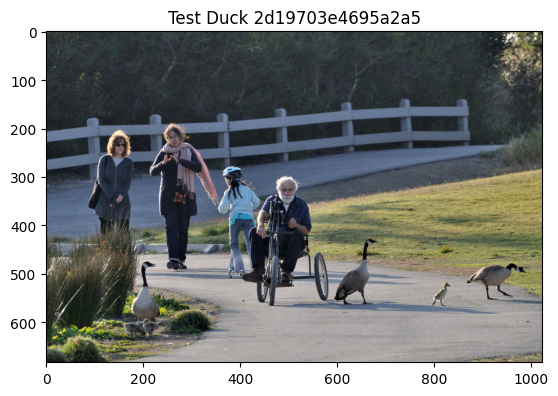

In [8]:
# Reading an Example Image from Duck Set
img_prefixes = [os.path.split(img)[1].split('.')[0] for img in os.listdir(f'{duckPath}/images/')]
img_prefix = random.choice(img_prefixes)
test_img = plt.imread(f'{duckPath}/images/{img_prefix}.jpg')
print(f'{color.BOLD}Test Duck Image{color.END}')
plt.figure()
plt.imshow(test_img)
plt.title(f'Test Duck {img_prefix}')
plt.show()

# Reading Bounding Box Labels for the Example Duck  Image
print(f'{color.BOLD}Test Duck ({img_prefix}) Image Labels{color.END}')
test_labels = open(f'{duckPath}/darknet/{img_prefix}.txt',newline='')
for label in test_labels.readlines():
    print(label,end='')
test_labels.close()

Let's make sense of the bounding box labels and visualize them by drawing the manually annotated bounding boxes to the image!

Test Duck (2d19703e4695a2a5) Image Labels
0 0.919375 0.7471855000000001 0.12875000000000003 0.11538499999999997
0 0.2009375 0.785647 0.06437499999999999 0.19606
0 0.20656249999999998 0.8991554999999999 0.02687500000000001 0.04971900000000007
0 0.6225 0.7359285 0.09249999999999992 0.21106899999999995
0 0.7940625 0.7945595 0.030624999999999902 0.07504699999999997
Test Duck 2d19703e4695a2a5 with Bounded Box Label


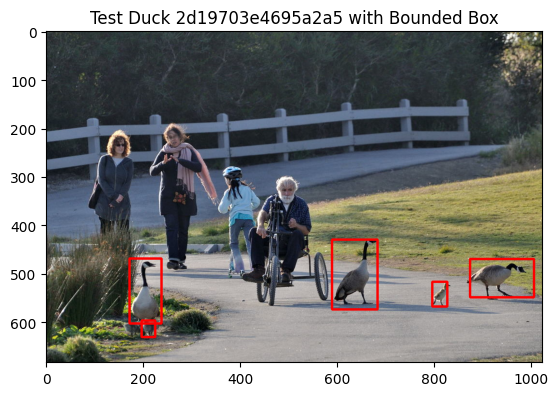

In [9]:
# Reading Test Duck Labels
test_label = open(f'{duckPath}/darknet/{img_prefix}.txt',newline='')
test_img_bounded = test_img.copy()
for label in test_label.readlines():
    test_img_bounded = drawBoundingBox(test_img_bounded,label)

# Displaying Bounded Box over the Duck Image
print(f'{color.BOLD}Test Duck {img_prefix} with Bounded Box Label{color.END}')
plt.figure()
plt.imshow(test_img_bounded)
plt.title(f'Test Duck {img_prefix} with Bounded Box')
plt.show()

Let's try the same bounding box visualization on the **Goose** subset.

Test Goose Image


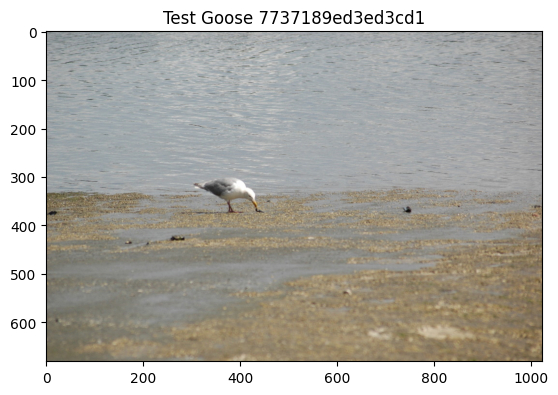

Test Goose (7737189ed3ed3cd1) Image Labels
0 0.36531250000000004 0.4868295 0.148125 0.11947300000000001

Test Goose 7737189ed3ed3cd1 with Bounded Box Label


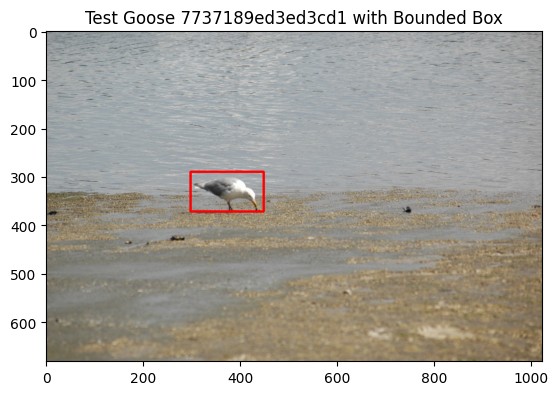

In [10]:
# Reading an Example Image from Goose Set
img_prefixes = [os.path.split(img)[1].split('.')[0] for img in os.listdir(f'{goosePath}/images/')]
img_prefix = random.choice(img_prefixes)
test_img = plt.imread(f'{goosePath}/images/{img_prefix}.jpg')
print(f'{color.BOLD}Test Goose Image{color.END}')
plt.figure()
plt.imshow(test_img)
plt.title(f'Test Goose {img_prefix}')
plt.show()

# Reading Bounding Box Labels for the Example Goose Image
print(f'{color.BOLD}Test Goose ({img_prefix}) Image Labels{color.END}')
test_labels = open(f'{goosePath}/darknet/{img_prefix}.txt',newline='')
test_img_bounded = test_img.copy()
for label in test_labels.readlines():
    test_img_bounded = drawBoundingBox(test_img_bounded,label)
    print(label,end='')
test_labels.close()

# Displaying Bounded Box over the Goose Image
print(f'\n{color.BOLD}Test Goose {img_prefix} with Bounded Box Label{color.END}')
plt.figure()
plt.imshow(test_img_bounded)
plt.title(f'Test Goose {img_prefix} with Bounded Box')
plt.show()

### Splitting Openimages Set into Train/Test/Val Subsets

For YOLOv8, the dataset needs to be split into training (train), validation (val), and testing (test) subsets to train the object detection model properly. The original Openimage subset structure for the Duck/Goose is as follows:
```
duck/
    darknet/
        001.txt
        002.txt
        ...
    images/
        001.jpg
        002.jpg
        ...
```

After conversion, the dataset should have a structure similar to below:

```
duck_train/
    classes.txt
    config.yaml
    images/
        train/
            001.txt
            002.txt
            ...
        val/
            003.txt
            004.txt
            ...
        test/
            005.txt
            006.txt
            ...
    images/
        train/
            001.jpg
            002.jpg
            ...
        val/
            003.jpg
            004.jpg
            ...
        test/
            005.jpg
            006.jpg
            ...
```

where ``classes.txt`` contains the name of the classes (i.e., Duck), and ``config.yaml`` contains the training configuration such as number of classes, location of train/val subsets, and class names. Below will define functions on converting the OpenImage datasets.




In [11]:
# Split an Openimage Set into Train/Val/Test Subsets
def splitOpenImages(ogPath,split=[0.9,0.05,0.05],seed=None):
    # Created Necessary Directories
    newPath = f'{os.path.dirname(ogPath)}_train'
    newImgPath = f'{newPath}/images'
    newLabelPath = f'{newPath}/labels'
    subsets = ['train','val','test']
    if(not(os.path.exists(newPath))): os.mkdir(newPath)
    if(not(os.path.exists(newImgPath))): os.mkdir(newImgPath)
    if(not(os.path.exists(newLabelPath))): os.mkdir(newLabelPath)
    # Create Train/Val/Test Subdirectories
    for mainDir in [newImgPath,newLabelPath]:
        for subset in subsets:
            subPath = f'{mainDir}/{subset}'
            if(not(os.path.exists(subPath))): os.mkdir(subPath)
    # Creating Dataset Config Files
    createClassFile(newPath)
    createYAMLConfig(newPath)
    # Getting Image Prefixes (Assuming 1-1 Correspondence between Images and Labels) & Shuffle Them
    prefixes = [os.path.split(img)[1].split('.')[0] for img in os.listdir(f'{ogPath}/images/')]
    N = len(prefixes)
    if(seed is not None): random.seed(seed) # Set random seed if manually entered
    random.shuffle(prefixes)
    j = 0
    for i,prefix in enumerate(prefixes):
        if j < len(subsets):
            if i < int(sum(split[:j+1])*N):
                shutil.copy2(f'{ogPath}/images/{prefix}.jpg',f'{newImgPath}/{subsets[j]}/{prefix}.jpg') # Copying Image
                shutil.copy2(f'{ogPath}/darknet/{prefix}.txt',f'{newLabelPath}/{subsets[j]}/{prefix}.txt') # Copying Label
            else: # Go on to Next Subset
                j += 1

# Create a YAML Config for the Dataset
def createYAMLConfig(dataPath):
    yamlPath = f'{dataPath}/config.yaml'
    yamlFile = open(yamlPath,'w',newline='')
    yamlFile.write(f'# DuckDetector config.yaml for {dataPath.split("/")[-1]}\n\n')
    yamlFile.write(f'# Data + Train/Val/Test Subset Paths\n')
    cwd = os.getcwd().replace("\\","//")
    yamlFile.write(f'path: {cwd}/{dataPath}\n')
    yamlFile.write('train: images/train\n')
    yamlFile.write('val: images/val\n')
    yamlFile.write('test: images/test\n\n')
    yamlFile.write(f'# Class Names\n')
    yamlFile.write('nc: 1\n')
    yamlFile.write('names:\n  0: Duck')
    yamlFile.close()

# Create a Class Name File for the Dataset
def createClassFile(dataPath):
    classPath = f'{dataPath}/classes.txt'
    classFile = open(classPath,'w',newline='')
    classFile.write('Duck')
    classFile.close()

In [12]:
# Spltting Open Images on Ducks (Set Manual Seed for Reproducible Results)
splitOpenImages(duckPath,seed=42)

# Spltting Open Images on Goose (Set Manual Seed for Reproducible Results)
splitOpenImages(goosePath,seed=42)

## Train an Initial Object Detection Model with YOLOv8
This section covers how to train an initial YOLOv8 model with the Openimages Duck/Goose Dataset.

In [19]:
# Smallest Base Pretrained Model
modelDir = './models'
modelPath = f'{modelDir}/OpenImageDuck_YOLOv8n.pt'
preTrained = True
if(not(os.path.exists(modelDir))): os.mkdir(modelDir)

if(not(preTrained)):
    model = ultralytics.YOLO('yolov8n.pt').to(device)
    # Train Model
    model.train(data='data/OpenImages/duck_train/config.yaml',epochs=25,batch=64,imgsz=640,verbose=True)
    # Final YOLOv8 Metrics
    metrics = model.val()
    # Saving Intial Model
    model.save(f'{modelPath}')
else:
    if(IN_COLAB):
        !curl https://raw.githubusercontent.com/dotimothy/DuckDetector/model/models/OpenImageDuck_YOLOv8n.pt -o {modelPath}
    model = ultralytics.YOLO(modelPath).to(device)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5993k  100 5993k    0     0  18.1M      0 --:--:-- --:--:-- --:--:-- 18.1M


In [20]:
# Results on the Test Set
results = model(f'data/OpenImages/duck_train/images/test')


image 1/64 /content/data/OpenImages/duck_train/images/test/009833f6d844072c.jpg: 576x640 8 Ducks, 61.5ms
image 2/64 /content/data/OpenImages/duck_train/images/test/01c531368944028e.jpg: 448x640 3 Ducks, 59.9ms
image 3/64 /content/data/OpenImages/duck_train/images/test/052de5baa09dd21f.jpg: 384x640 2 Ducks, 84.3ms
image 4/64 /content/data/OpenImages/duck_train/images/test/086f2fc2dd077bf8.jpg: 640x640 11 Ducks, 7.9ms
image 5/64 /content/data/OpenImages/duck_train/images/test/0a08536ee1162346.jpg: 448x640 2 Ducks, 7.9ms
image 6/64 /content/data/OpenImages/duck_train/images/test/0e6be37ec4894315.jpg: 512x640 1 Duck, 63.6ms
image 7/64 /content/data/OpenImages/duck_train/images/test/11fe2a3d6d159fb9.jpg: 416x640 1 Duck, 60.2ms
image 8/64 /content/data/OpenImages/duck_train/images/test/1c8278106e96f767.jpg: 480x640 1 Duck, 58.9ms
image 9/64 /content/data/OpenImages/duck_train/images/test/1f13d8a4f4f78b54.jpg: 416x640 7 Ducks, 7.0ms
image 10/64 /content/data/OpenImages/duck_train/images/test

In [21]:
# Results on the Blind Set! (Video Outside of the Dataset)
resDir = './results'
if(not(os.path.exists(resDir))): os.mkdir(resDir)
print('Testing Model on Real World Videos!')
print(f'{color.BOLD}Video 1.{color.END} Fountain')
os.system(f"yolo predict model='./models/OpenImageDuck_YOLOv8n.pt' source='https://timothydo.me/RefreshVideos/media/fountain.mp4' project='./results' name='fountain' device={'cuda' if use_cuda else 'mps' if use_mps else 'cpu'}")
os.remove('./fountain.mp4')
print(f'{color.BOLD}Video 2.{color.END} Feeding Ducks')
os.system(f"yolo predict model='./models/OpenImageDuck_YOLOv8n.pt' source='https://timothydo.me/RefreshVideos/media/duck.mp4' project='./results' name='duck' device={'cuda' if use_cuda else 'mps' if use_mps else 'cpu'}")
os.remove('./duck.mp4')
# Converting
if(sys.platform == 'darwin'): # MacOS
    shutil.copy2('./results/duck/duck.mp4','./results/duck.mp4')
    shutil.copy2('./results/fountain/fountain.mp4','./results/fountain.mp4')
else: # Non-MacOS
    os.system('ffmpeg -i "./results/duck/duck.avi" "./results/duck.mp4"')
    os.system('ffmpeg -i "./results/fountain/fountain.avi" "./results/fountain.mp4"')
shutil.rmtree('./results/duck/')
shutil.rmtree('./results/fountain/')

Testing Model on Real World Videos!
Video 1. Fountain
Video 2. Feeding Ducks


Let's look at the Initial Fruits of Our Work!

In [22]:
print(f'{color.BOLD}Annotated Fountain Video{color.END}')
Video('./results/fountain.mp4',embed=True)

Annotated Fountain Video


In [23]:
print(f'{color.BOLD}Annotated Duck Video{color.END}')
Video('./results/Duck.mp4',embed=True)

Annotated Duck Video
